In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

In [34]:
# global variable 
GAMMA = 1.5 # risk aversion
RF = 2 #risk-free rate

# risk-averse utility function #

In [3]:
def crra(x, gamma=GAMMA):
    if gamma != 0:
        return (1- math.exp(-gamma*x))/(gamma)
    else:
        return x

In [ ]:
def calc_return_portfolio(x, sigma):
    pi = (x-RF)/(GAMMA*sigma**2)
    pi = min(max(0, pi),1)
    return RF + pi * (x - RF)

W $\sim$ N(1+rf + $\pi$ *($\mu$ - rf), $ \pi^2 \sigma ^2$), where $\pi$ is the proportion invested into the risky asset


$\pi^* = \frac{\mu - rf}{\gamma * \sigma^2}$ is the optimal investment into the risky asset

# Using Thompson Sampling to decide between two assets

In [12]:
class Asset:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
       
        
    def get_return_from_true_distribution(self):   
        r = np.random.normal(self.mu, self.sigma**2)
        self.n += 1
        self.sum_return += r
        return r

# Thompson Sampling

In [13]:
class AssetThompsonSampler(Asset):
    def __init__(self, mu, sigma):
        # initial distribution
        self.prior_mu = 0 # initially no idea which asset is best
        self.prior_sigma = 1000 # flat distribution as no prior
        
        self.post_mu = self.prior_mu # posterior mu
        self.post_sigma = self.prior_sigma #posterior sigma
        
        self.n = 0
        self.sum_return = 0
        
        super().__init__(mu, sigma)
        
    def get_return_estimated_distribution(self):
        r = np.random.normal(self.post_mu, self.post_sigma**2)
        return calc_return_portfolio(r,self.post_sigma)
    
    def update_estimated_distribution(self):
        self.post_sigma = np.sqrt((1 / self.prior_sigma**2 + self.n / self.sigma**2)**-1)
        self.post_mu = (self.post_sigma**2) * ((self.prior_mu / self.prior_sigma**2) + (self.sum_return / self.sigma**2))

In [6]:
def draw_distributions(R,i):
    for r in R:
        samps = np.random.normal(r.post_mu, r.post_sigma, 10000)
        sns.kdeplot(samps, shade=True)
    plt.title('Iteration %s'%(i+1), fontsize=16)
    plt.legend(['mu=%s'%(r.mu) for r in R], fontsize=12)
    plt.xlim(-1,10)
    plt.xlabel('Expected Return', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    
    plt.show()

In [36]:
mu = 3
sigma = 1
pi = (mu - RF)/(GAMMA*sigma**2)
exp_mu = RF+pi*(mu - RF)
pi, exp_mu

(0.6666666666666666, 2.6666666666666665)

In [35]:
mu = 5
sigma = 2
pi = (mu - RF)/(GAMMA*sigma**2)
exp_mu = RF+pi*(mu - RF)
pi, exp_mu

(0.5, 3.5)

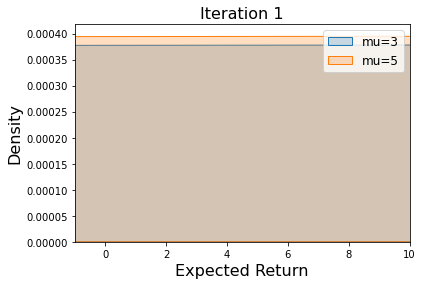

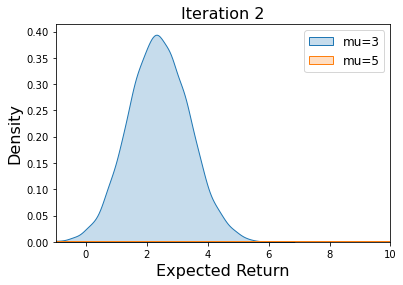

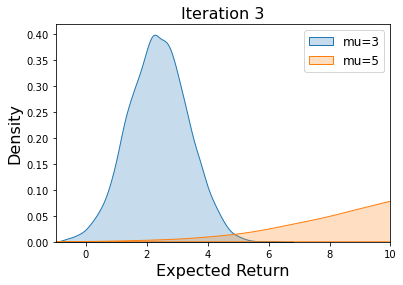

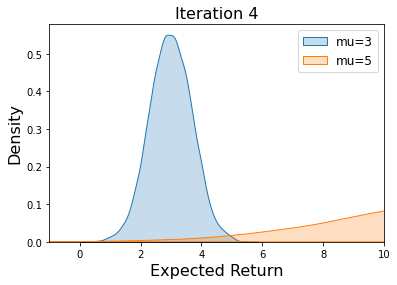

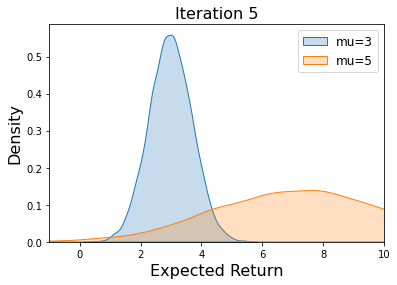

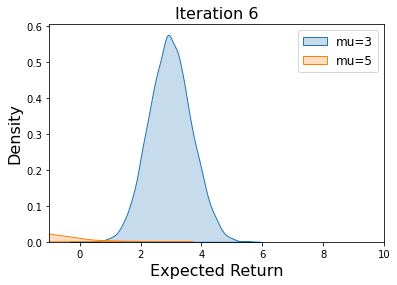

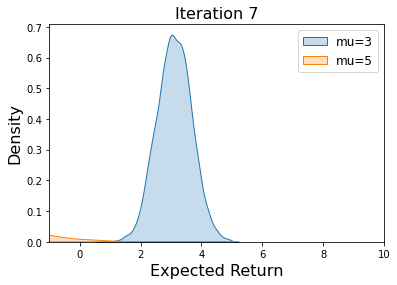

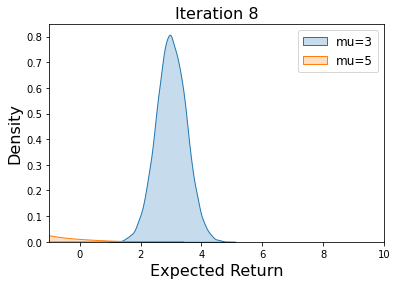

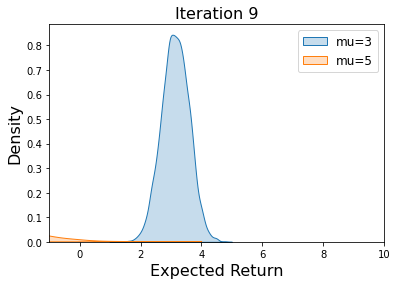

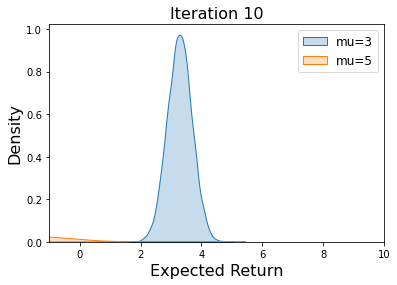

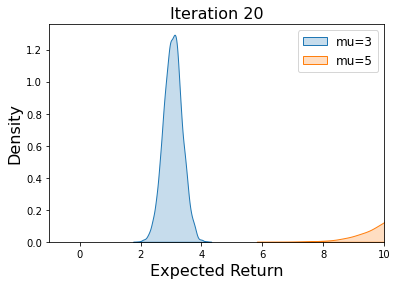

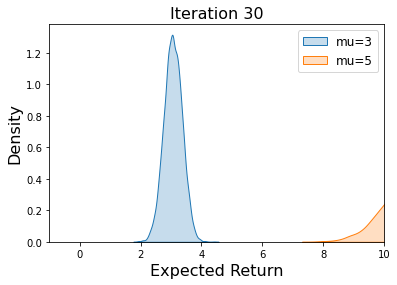

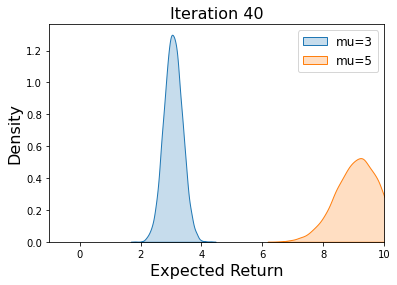

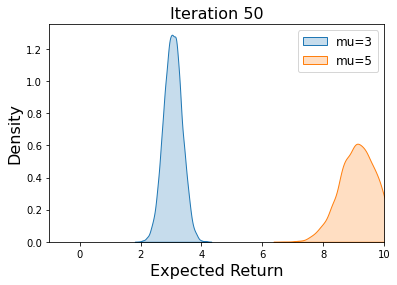

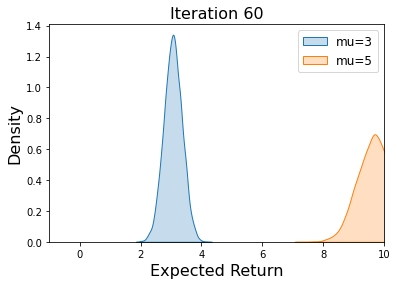

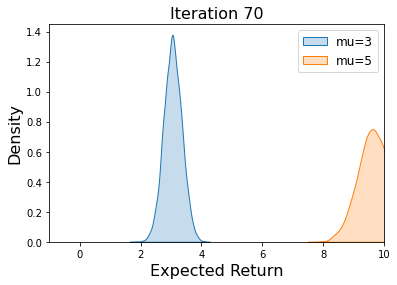

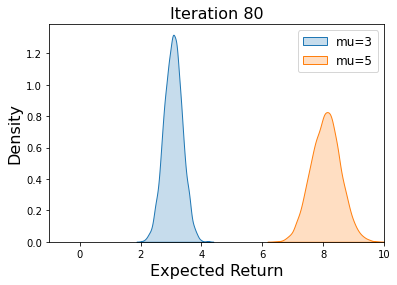

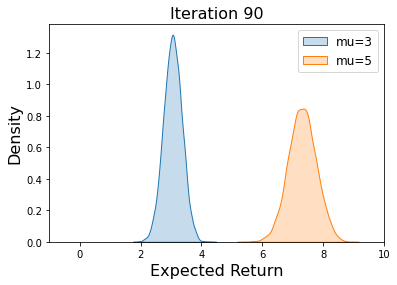

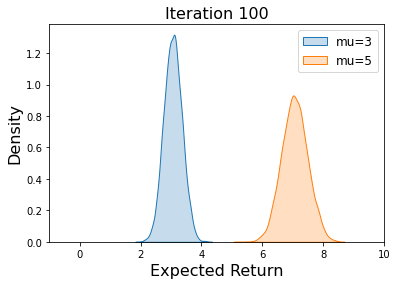

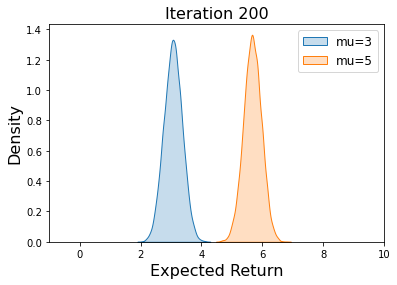

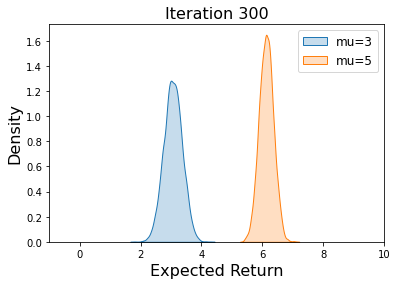

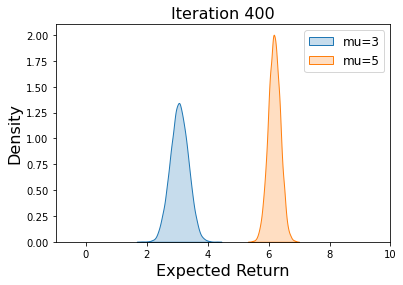

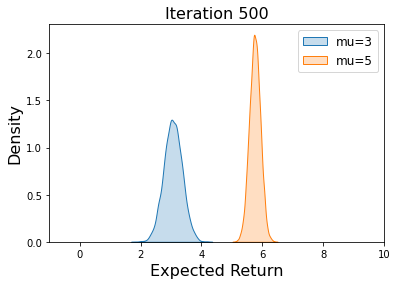

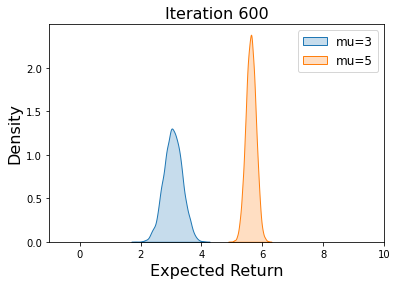

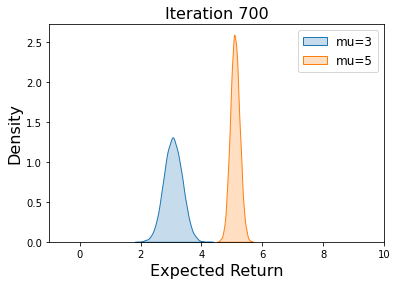

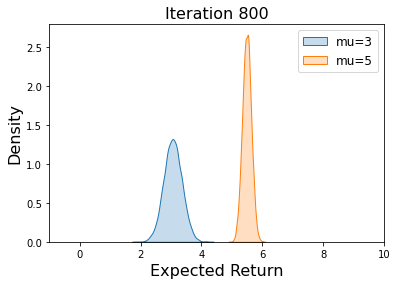

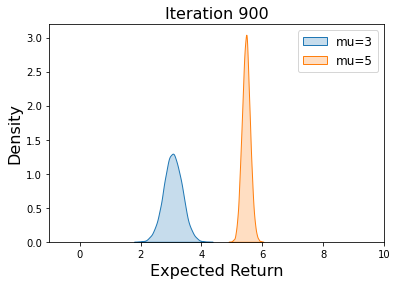

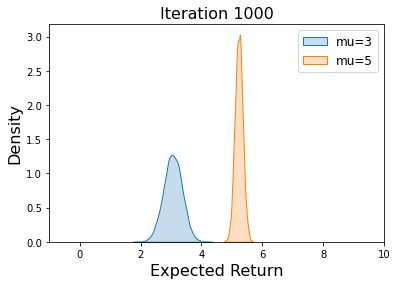

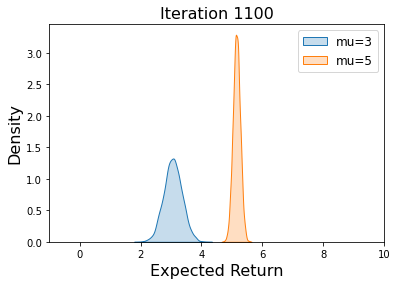

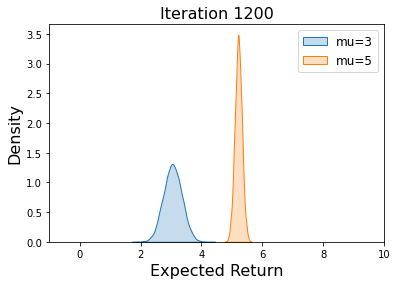

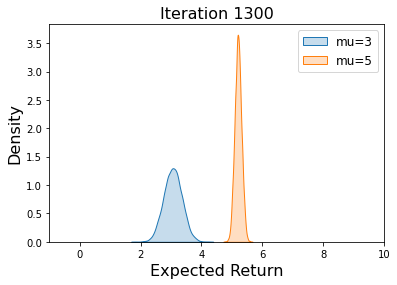

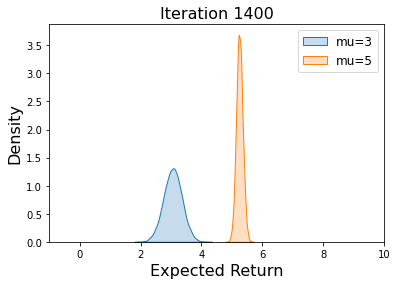

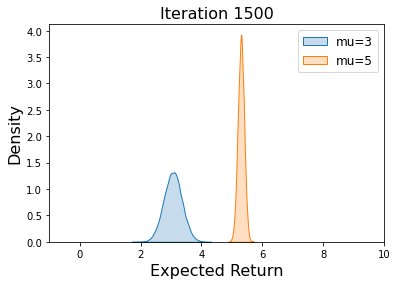

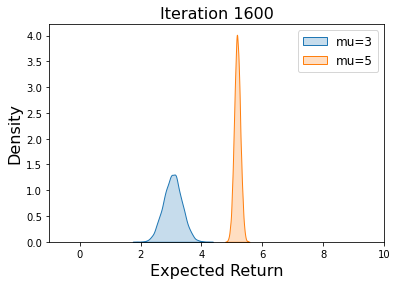

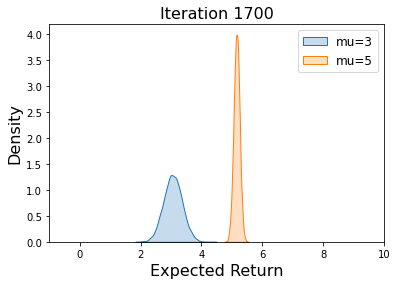

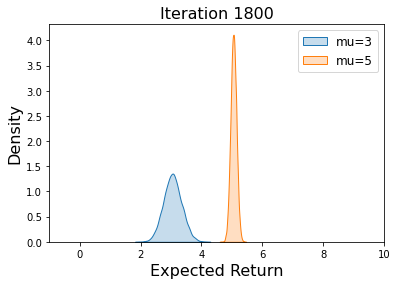

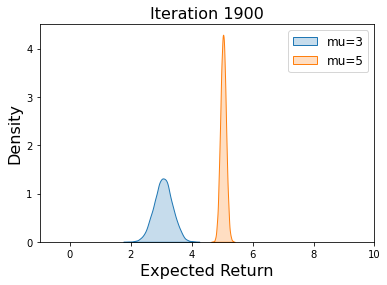

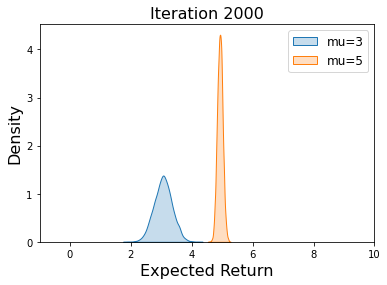

In [37]:
num_assets = 2

#Collection_of_assets = AssetThompsonSampler(asset_one, asset_two)
#Collection_of_assets = [AssetThompsonSampler(1.5+i, 1.5**(i-1)) for i in range(1, num_assets+1)]
Collection_of_assets = [AssetThompsonSampler(3, 1), AssetThompsonSampler(5, 2**2)]

for i in range(2000):
    if num_assets <= 10 and (i < 10 or (i < 100 and (i+1) % 10 == 0) or ((i+1) % 100 == 0)):
        draw_distributions(Collection_of_assets,i)
    
    #get a sample from each posterior
    post_samps = [asset.get_return_estimated_distribution() for asset in Collection_of_assets]
    #index of distribution with highest satisfaction
    chosen_idx = post_samps.index(max(post_samps))
    
    #get a new sample from that distribution
    s = Collection_of_assets[chosen_idx].get_return_from_true_distribution()
    
    #update that distributions posterior
    Collection_of_assets[chosen_idx].update_estimated_distribution()

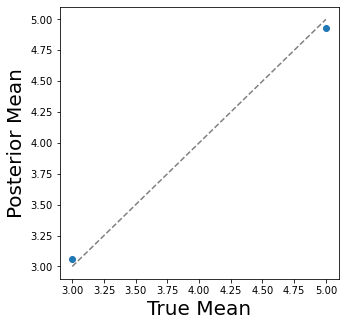

In [41]:
plt.figure(figsize=(5,5))
true_means = [r.mu for r in Collection_of_assets]
posterior_means = [r.post_mu for r in Collection_of_assets]
plt.scatter(true_means, posterior_means)
plt.plot(true_means, true_means, color='k', alpha=0.5, linestyle='--')

plt.xlabel('True Mean', fontsize=20)
plt.ylabel('Posterior Mean', fontsize=20)
plt.show()